<a href="https://colab.research.google.com/github/Sarah-0405/Bachelorarbeit_/blob/main/CORINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 23.6 MB/s eta 0:00:00


In [ ]:
import ee
import geemap
import folium
import geopandas as gpd
from google.colab import files
import zipfile
import os
import rasterio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
ee.Authenticate()
ee.Initialize(project="ee-sarahheinz0405")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
clc = ee.Image("COPERNICUS/CORINE/V20/100m/2018")


In [ ]:
print(clc.getInfo())

{'type': 'Image', 'bands': [{'id': 'landcover', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'dimensions': [65000, 46000], 'crs': 'EPSG:3035', 'crs_transform': [100, 0, 900000, 0, -100, 5500000]}], 'version': 1578598451411424, 'id': 'COPERNICUS/CORINE/V20/100m/2018', 'properties': {'system:time_start': 1483228800000, 'landcover_class_names': ['Artificial surfaces; urban fabric; continuous urban fabric', 'Artificial surfaces; urban fabric; discontinuous urban fabric', 'Artificial surfaces; industrial, commercial, and transport units; industrial or commercial units', 'Artificial surfaces; industrial, commercial, and transport units; road and rail networks and associated land', 'Artificial surfaces; industrial, commercial, and transport units; port areas', 'Artificial surfaces; industrial, commercial, and transport units; airports', 'Artificial surfaces; mine, dump, and construction sites; mineral extraction sites', 'Artificial surfaces; mine, dump,

In [ ]:
# Alle Landnutzungsklassen abrufen
klassen = clc.get('landcover_class_names').getInfo() # Use .getInfo() to retrieve the data

print(klassen)

['Artificial surfaces; urban fabric; continuous urban fabric', 'Artificial surfaces; urban fabric; discontinuous urban fabric', 'Artificial surfaces; industrial, commercial, and transport units; industrial or commercial units', 'Artificial surfaces; industrial, commercial, and transport units; road and rail networks and associated land', 'Artificial surfaces; industrial, commercial, and transport units; port areas', 'Artificial surfaces; industrial, commercial, and transport units; airports', 'Artificial surfaces; mine, dump, and construction sites; mineral extraction sites', 'Artificial surfaces; mine, dump, and construction sites; dump sites', 'Artificial surfaces; mine, dump, and construction sites; construction sites', 'Artificial surfaces; artificial, non-agricultural vegetated areas; green urban areas', 'Artificial surfaces; artificial, non-agricultural vegetated areas; sport and leisure facilities', 'Agricultural areas; arable land; non-irrigated arable land', 'Agricultural area

# Gruppieren und Visualisieren

In [ ]:
# 4. Definition der CORINE-Gruppierung und Farbpalette
gruppen = {
    'Urbane Strukturen': [111, 112],
    'Industriegebiete': [121, 122, 123, 124],
    'Verkehrslinien': [131, 132, 133],
    'urbane Grünflaechen': [141, 142],
    'Waelder': [311, 312, 313, 321, 322, 323, 324],
    'Gewaesser': [511, 512, 521, 522, 523],
    'Landwirtschaft': [211, 242, 243, 231, 221, 222, 223, 241, 212, 213, 244]
}

farben = {
    'Urbane Strukturen': '#F5F5DC',  # beige
    'Industriegebiete': '#696969', # dunkelgrau
    'Verkehrslinien': '#D3D3D3', #dunkelgrau
    'urbane Grünflaechen': '#90EE90',  #hellgrün
    'Waelder': '#006400',  # dunklegrün
    'Gewaesser': '#0000FF',  #blau
    'Landwirtschaft': '#FFA07A' #lachs
}

# Erstelle Listen für Remapping: Für jeden CORINE-Code wird ein Gruppenindex vergeben.
# Wir ordnen den Gruppen fortlaufend die IDs 1 bis 7 zu.
group_order = ['Urbane Strukturen', 'Industriegebiete', 'Verkehrslinien',
               'urbane Grünflaechen', 'Waelder', 'Gewaesser', 'Landwirtschaft']

old_values = []
new_values = []
for i, group in enumerate(group_order, start=1):
    codes = gruppen[group]
    for code in codes:
        old_values.append(code)
        new_values.append(i)

# Palette in derselben Reihenfolge wie group_order:
palette = [farben[group] for group in group_order]

# 5. Funktion: Shapefile (mittels GeoPandas) in ein EE-FeatureCollection umwandeln
def shapefile_to_ee_fc(shp_path):
    # Lese das Shapefile ein und reprojiziere nach EPSG:4326 (WGS84)
    gdf = gpd.read_file(shp_path)
    gdf = gdf.to_crs(epsg=4326)
    features = []
    for _, row in gdf.iterrows():
        geom = ee.Geometry(row['geometry'].__geo_interface__)
        # Optional: Füge einen Eigenschaftswert (z.B. "name") hinzu, falls vorhanden
        feature = ee.Feature(geom)
        features.append(feature)
    return ee.FeatureCollection(features)

# 6. Lade die Shapefiles für Nördlingen, Kempten und Ingolstadt aus Google Drive
noerdlingen_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp'
kempten_shapefile   = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp'
ingolstadt_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'

noerdlingen_fc = shapefile_to_ee_fc(noerdlingen_shapefile)
kempten_fc     = shapefile_to_ee_fc(kempten_shapefile)
ingolstadt_fc  = shapefile_to_ee_fc(ingolstadt_shapefile)

# Optional: Alle Regionen in einer einzigen FeatureCollection zusammenführen
region_fc = noerdlingen_fc.merge(kempten_fc).merge(ingolstadt_fc)

# 7. CORINE Land Cover-Daten laden und gruppieren
clc = ee.Image("COPERNICUS/CORINE/V20/100m/2018")
# Die CORINE-Bandbezeichnung ist "landcover". Mithilfe von remap ordnen wir den Pixeln die Gruppen-IDs zu.
clc_grouped = clc.select('landcover').remap(old_values, new_values, 0)  # 0 als Default-Wert

# 8. Visualisierungseinstellungen für die gruppierten Daten
group_vis = {
    'min': 1,
    'max': 7,
    'palette': palette
}

# 9. Erstelle eine interaktive Karte und visualisiere:
Map = geemap.Map(center=[48.7, 10.5], zoom=8)
# Zeige das gruppierte CORINE-Bild, auf die kombinierte Region (Städtegrenzen) zugeschnitten
Map.addLayer(clc_grouped.clip(region_fc), group_vis, "CLC Gruppen")
# Optional: Zeige die Umrisse der Shapefiles (Städtegrenzen) in schwarz
Map.addLayer(region_fc.style(**{'color': 'black', 'fillColor': '00000000', 'width': 0.5}), {}, "Städtegrenzen")
Map.add_layer_control()  # Layer-Steuerelement hinzufügen


# Legende hinzufügen
legend_dict = {group: farben[group] for group in gruppen}  # Create legend_dict with group names and colors

Map.add_legend(legend_dict=legend_dict, title="Landnutzungsklassen", position='topleft')  # Add legend with group names
Map


Map(center=[48.7, 10.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [ ]:
# Definiere die Region, für die du die Daten extrahieren möchtest (z.B. region_fc)
region = region_fc

# Extrahiere die Landnutzungsdaten für die Region aus dem gruppierten CORINE-Bild
landnutzung = clc_grouped.sample(region=region, scale=100, geometries=True) # scale=100 entspricht der Auflösung des CORINE-Bildes

In [87]:
print(region_fc.getInfo())

{'type': 'FeatureCollection', 'columns': {'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[10.535402117336032, 48.922162609783555], [10.53317782685517, 48.92257700691586], [10.53196918649091, 48.92083563342857], [10.530025920564633, 48.91627756851314], [10.528426648532655, 48.91419750406397], [10.527162526429207, 48.91331736841397], [10.524525574598492, 48.91048626160172], [10.521056807410675, 48.90885860685453], [10.521744791272686, 48.90822622601505], [10.522394357215848, 48.90775018015374], [10.52315226251487, 48.90739308680957], [10.523982377149888, 48.90708356485787], [10.525028958925484, 48.90655982498229], [10.525786789587594, 48.906131326467225], [10.526508494306533, 48.90567903595876], [10.527049662116276, 48.90515539735108], [10.519974664851853, 48.90515688873535], [10.517447580425845, 48.90432445711138], [10.514856799409868, 48.90409883163938], [10.515458975222268, 48.89394978504724], [10.514412463252127, 48.894140

In [ ]:
# Exportieren Sie die FeatureCollection in einen GeoDataFrame
landnutzung_gdf = geemap.ee_export_vector(landnutzung, filename="landnutzung.shp")

# Geben Sie den GeoDataFrame aus
landnutzung_gdf = gpd.read_file("landnutzung.shp")

print(landnutzung_gdf.head())

Generating URL ...
Please wait ...
Data downloaded to /content/landnutzung.shp
   remapped                   geometry
0         7   POINT (10.27937 47.7773)
1         7    POINT (10.2807 47.7773)
2         7   POINT (10.28204 47.7773)
3         7   POINT (10.2887 47.77728)
4         5  POINT (10.29004 47.77728)


# Kombination LST und Corine Daten

In [17]:
landnutzung_gdf = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Landnutzung/landnutzung.shp")
print(landnutzung_gdf.head())

   remapped                   geometry
0         7   POINT (10.27937 47.7773)
1         7    POINT (10.2807 47.7773)
2         7   POINT (10.28204 47.7773)
3         7   POINT (10.2887 47.77728)
4         5  POINT (10.29004 47.77728)


In [20]:
# Extrahiere lat und long aus den Koordinaten

landnutzung_gdf["latitude"] = landnutzung_gdf["geometry"].y
landnutzung_gdf["longitude"] = landnutzung_gdf["geometry"].x

In [24]:
print(landnutzung_gdf.head(10))

   remapped                   geometry   latitude  longitude
0         7   POINT (10.27937 47.7773)  47.777305  10.279368
1         7    POINT (10.2807 47.7773)  47.777301  10.280702
2         7   POINT (10.28204 47.7773)  47.777298  10.282035
3         7   POINT (10.2887 47.77728)  47.777281  10.288703
4         5  POINT (10.29004 47.77728)  47.777277  10.290036
5         5  POINT (10.29137 47.77727)  47.777274  10.291370
6         5   POINT (10.2927 47.77727)  47.777270  10.292703
7         5  POINT (10.29404 47.77727)  47.777266  10.294037
8         7  POINT (10.27803 47.77641)  47.776408  10.278030
9         7   POINT (10.27936 47.7764)  47.776405  10.279363


In [75]:
# Datensätze zusammenführen

# Definiere eine Funktion für den Spatial Join mit angepasster Geometrie

def spatial_join_with_rounding(lst_gdf, landnutzung_gdf, buffer_distance=0.001):
  """Führt einen Spatial Join mit Rundung der Koordinaten durch.

  Args:
      lst_gdf (gpd.GeoDataFrame): GeoDataFrame mit den LST-Daten.
      landnutzung_gdf (gpd.GeoDataFrame): GeoDataFrame mit den Landnutzung.

  Returns:
      gpd.Geodataframe: GeoDataFrame mit den kombinierten Daten.
  """

  landnutzung_gdf = landnutzung_gdf.to_crs(lst_gdf.crs)

  # Ensure 'latitude' and 'longitude' columns exist in landnutzung_gdf
  if 'latitude' not in landnutzung_gdf.columns:
    landnutzung_gdf["latitude"] = landnutzung_gdf["geometry"].y
  if 'longitude' not in landnutzung_gdf.columns:
    landnutzung_gdf["longitude"] = landnutzung_gdf["geometry"].x


  # Runden der Koordinaten auf 3 Dezimalstellen
  lst_gdf['latitude'] = lst_gdf ['latitude']. round (3)
  lst_gdf ['longitude'] = lst_gdf ['longitude']. round (3)
  landnutzung_gdf ['latitude'] = landnutzung_gdf ['latitude']. round (3)
  landnutzung_gdf ['longitude'] = landnutzung_gdf ['longitude']. round (3)

  # Add buffer to landnutzung_gdf geometries to ensure intersection
  landnutzung_gdf['geometry'] = landnutzung_gdf['geometry'].buffer(buffer_distance)


  # Spatial Join durchführen
  combined_gdf = gpd.sjoin(lst_gdf, landnutzung_gdf[['remapped', 'geometry', 'latitude', 'longitude']], how='inner', predicate='intersects')

  # Umbenennen der Spalte 'remapped' in 'Landnutzung'
  combined_gdf = combined_gdf. rename(columns={'remapped':'Landnutzung'})

  return combined_gdf

# Lade die LST-Daten als GeoDataFrames
noerdlingen_LST_path = '/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/LST_Noerdlingen_summer2022_5%_with_coords_reexported.csv'
kempten_LST_path = '/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/LST_Kempten_summer2022_5%_with_coords.csv'
ingolstadt_LST_path = '/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/LST_Ingolstadt_summer2022_5%_with_coords.csv'

# Load CSV files as DataFrames using pandas
noerdlingen_lst_df = pd.read_csv(noerdlingen_LST_path)
kempten_lst_df = pd.read_csv(kempten_LST_path)
ingolstadt_lst_df = pd.read_csv(ingolstadt_LST_path)

# Convert DataFrames to GeoDataFrames
noerdlingen_lst_gdf = gpd.GeoDataFrame(noerdlingen_lst_df, geometry=gpd.points_from_xy(noerdlingen_lst_df.longitude, noerdlingen_lst_df.latitude), crs='EPSG:4326')
kempten_lst_gdf = gpd.GeoDataFrame(kempten_lst_df, geometry=gpd.points_from_xy(kempten_lst_df.longitude, kempten_lst_df.latitude), crs='EPSG:4326')
ingolstadt_lst_gdf = gpd.GeoDataFrame(ingolstadt_lst_df, geometry=gpd.points_from_xy(ingolstadt_lst_df.longitude, ingolstadt_lst_df.latitude), crs='EPSG:4326')


# Führe den Spatial Join für jede Stadt durch
noerdlingen_combined = spatial_join_with_rounding(noerdlingen_lst_gdf, landnutzung) # Pass the GeoDataFrame
kempten_combined = spatial_join_with_rounding (kempten_lst_gdf, landnutzung)       # Pass the GeoDataFrame
ingolstadt_combined = spatial_join_with_rounding (ingolstadt_lst_gdf, landnutzung)    # Pass the GeoDataFrame


print(kempten_combined.head())


   longitude_left  latitude_left  system:index  LST_Celsius  \
0          10.318         47.695             0    26.112141   
1          10.318         47.695             1    24.783385   
2          10.318         47.695             2    25.025210   
3          10.319         47.695             3    25.025210   
3          10.319         47.695             3    25.025210   

                    geometry  index_right  Landnutzung  latitude_right  \
0  POINT (10.31773 47.69529)         6319            4          47.696   
1    POINT (10.318 47.69529)         6321            4          47.695   
2  POINT (10.31827 47.69529)         6321            4          47.695   
3  POINT (10.31854 47.69529)         6321            4          47.695   
3  POINT (10.31854 47.69529)         6320            4          47.696   

   longitude_right  
0           10.318  
1           10.319  
2           10.319  
3           10.319  
3           10.319  


In [79]:
# Überprüfen auf den Wert 0
zero_values_k = (kempten_combined['Landnutzung'] == 0).sum()
zero_values_i = (ingolstadt_combined['Landnutzung'] == 0).sum()
zero_values_n = (noerdlingen_combined['Landnutzung'] == 0).sum()

print(f"Anzahl der Werte gleich 0 (Kempten): {zero_values_k}")
print(f"Anzahl der Werte gleich 0 (Ingolstadt): {zero_values_i}")
print(f"Anzahl der Werte gleich 0 (Noerdlingen): {zero_values_n}")


Anzahl der Werte gleich 0 (Kempten): 565
Anzahl der Werte gleich 0 (Ingolstadt): 0
Anzahl der Werte gleich 0 (Noerdlingen): 0


bei Kempten werden einige LST Werte keiner Corine Gruppe zugeordnet. da dies aber verhältnismäßig wenige sind (565 von 258232) und bei den anderen Städten keine, werden die 0 Spalten bei den statistischen Analysen einfach herausgenommen.

In [56]:
# Drop 'system:index' column from all three GeoDataFrames
noerdlingen_combined = noerdlingen_combined.drop(columns=['system:index'])
kempten_combined = kempten_combined.drop(columns=['system:index'])
ingolstadt_combined = ingolstadt_combined.drop(columns=['system:index'])

# Rename columns for all three GeoDataFrames
def rename_columns(gdf):
    renamed_cols = {col: col.replace('_left', '_lst').replace('_right', '_landnutzung') for col in gdf.columns}
    return gdf.rename(columns=renamed_cols)

noerdlingen_combined = rename_columns(noerdlingen_combined)
kempten_combined = rename_columns(kempten_combined)
ingolstadt_combined = rename_columns(ingolstadt_combined)

# Print the updated GeoDataFrames (optional)
print(noerdlingen_combined.head())
print(kempten_combined.head())
print(ingolstadt_combined.head())

   longitude_lst  latitude_lst  LST_Celsius                   geometry  \
0         10.506        48.795    32.226124  POINT (10.50557 48.79536)   
1         10.506        48.795    32.134692  POINT (10.50584 48.79536)   
2         10.506        48.795    31.939865  POINT (10.50611 48.79536)   
2         10.506        48.795    31.939865  POINT (10.50611 48.79536)   
3         10.506        48.795    31.939865  POINT (10.50638 48.79536)   

   index_landnutzung  Landnutzung  latitude_landnutzung  longitude_landnutzung  
0              14437            7                48.796                 10.505  
1              14437            7                48.796                 10.505  
2              14438            7                48.796                 10.507  
2              14437            7                48.796                 10.505  
3              14438            7                48.796                 10.507  
   longitude_lst  latitude_lst  LST_Celsius                   geometr

In [31]:
# Export each GeoDataFrame to a separate layer in a Geopackage
noerdlingen_combined.to_file("combined_data.gpkg", layer="noerdlingen", driver="GPKG")
kempten_combined.to_file("combined_data.gpkg", layer="kempten", driver="GPKG")
ingolstadt_combined.to_file("combined_data.gpkg", layer="ingolstadt", driver="GPKG")

In [57]:
combined_noerdlingen = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Landnutzung/combined_data_LST_Landnutzung.gpkg", layer="noerdlingen")
combined_kempten = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Landnutzung/combined_data_LST_Landnutzung.gpkg", layer="kempten")
combined_ingolstadt = gpd.read_file("/content/drive/MyDrive/Daten BA /erstellte Dateien mit colab/Landnutzung/combined_data_LST_Landnutzung.gpkg", layer="ingolstadt")

In [59]:
print(combined_noerdlingen.head())

   longitude_lst  latitude_lst  LST_Celsius  index_landnutzung  Landnutzung  \
0         10.506        48.795    32.226124              14437            7   
1         10.506        48.795    32.134692              14437            7   
2         10.506        48.795    31.939865              14438            7   
3         10.506        48.795    31.939865              14437            7   
4         10.506        48.795    31.939865              14438            7   

   latitude_landnutzung  longitude_landnutzung                   geometry  
0                48.796                 10.505  POINT (10.50557 48.79536)  
1                48.796                 10.505  POINT (10.50584 48.79536)  
2                48.796                 10.507  POINT (10.50611 48.79536)  
3                48.796                 10.505  POINT (10.50611 48.79536)  
4                48.796                 10.507  POINT (10.50638 48.79536)  


In [81]:
zero_values_k = (combined_kempten['Landnutzung'] == 0).sum()
print(f"Anzahl der Werte gleich 0 (Kempten): {zero_values_k}")


Anzahl der Werte gleich 0 (Kempten): 565


# statistische Analysen

In [84]:
# Definiere die Landnutzungsgruppen und Farben
gruppen = {
    1: 'Urbane Strukturen',
    2: 'Industriegebiete',
    3: 'Verkehrslinien',
    4: 'urbane Grünflaechen',
    5: 'Waelder',
    6: 'Gewaesser',
    7: 'Landwirtschaft'
}

farben = {
    'Urbane Strukturen': '#F5F5DC',  # beige
    'Industriegebiete': '#696969',  # dunkelgrau
    'Verkehrslinien': '#000000',  # schwarz
    'urbane Grünflaechen': '#90EE90',  # hellgrün
    'Waelder': '#006400',  # dunkelgrün
    'Gewaesser': '#0000FF',  # blau
    'Landwirtschaft': '#CC7722'  # ockerbraun
}



In [82]:
def calculate_lst_stats(gdf, city_name):
    """Berechnet LST-Statistiken für jede Landnutzungsgruppe.

    Args:
        gdf (gpd.GeoDataFrame): GeoDataFrame mit LST- und Landnutzungsdaten.
        city_name (str): Name der Stadt.

    Returns:
        pd.DataFrame: DataFrame mit den berechneten Statistiken.
    """

    # Filtern des DataFrames, um Zeilen mit Landnutzung == 0 zu entfernen
    filtered_gdf = gdf[gdf['Landnutzung'] != 0]

    # Gruppiere nach Landnutzung und berechne Statistiken
    stats = filtered_gdf.groupby('Landnutzung')['LST_Celsius'].agg(['mean', 'min', 'max'])

    # Benenne die Spalten um
    stats = stats.rename(columns={
        'mean': 'LST_Mittelwert',
        'min': 'LST_Minimum',
        'max': 'LST_Maximum'
    })

    # Füge eine Spalte für den Städtenamen hinzu
    stats['Stadt'] = city_name

    return stats

# Berechne Statistiken für jede Stadt
noerdlingen_stats = calculate_lst_stats(combined_noerdlingen, 'Nördlingen')
kempten_stats = calculate_lst_stats(combined_kempten, 'Kempten')
ingolstadt_stats = calculate_lst_stats(combined_ingolstadt, 'Ingolstadt')

# Kombiniere die Ergebnisse in einem DataFrame
all_stats = pd.concat([noerdlingen_stats, kempten_stats, ingolstadt_stats])

# Setze die Landnutzung als Index
all_stats = all_stats.reset_index()

# Gib die Ergebnisse aus
print(all_stats)

    Landnutzung  LST_Mittelwert  LST_Minimum  LST_Maximum       Stadt
0             1       38.311834    31.745892    45.891368  Nördlingen
1             2       40.767770    32.838804    49.760567  Nördlingen
2             4       35.848473    31.580118    42.454549  Nördlingen
3             5       34.942576    28.586787    42.962979  Nördlingen
4             7       35.871145    29.912979    45.604254  Nördlingen
5             1       34.812040    25.273017    44.137924     Kempten
6             2       36.782717    25.665235    43.623512     Kempten
7             4       30.073122    24.302299    41.678658     Kempten
8             5       28.435154    24.671445    38.369160     Kempten
9             7       31.095714    22.301903    41.952100     Kempten
10            1       36.771208    24.587419    45.643562  Ingolstadt
11            2       38.677597    24.408543    55.726721  Ingolstadt
12            3       36.354042    26.836476    42.730269  Ingolstadt
13            4     

prozentualer Anteil der Landnutzungsgruppe an Gesamt-Stadtfläche

In [89]:
def calculate_landuse_area_with_region(combined_gdf, region_fc, city_name):
    """
    Calculates the area of each land use class within city boundaries using region_fc polygons.

    Args:
        combined_gdf (gpd.GeoDataFrame): GeoDataFrame with LST and land use data (points).
        region_fc (ee.FeatureCollection): FeatureCollection with city boundary polygons.
        city_name (str): Name of the city.

    Returns:
        pd.DataFrame: DataFrame with calculated areas for each land use class.
    """

    # Convert region_fc to GeoDataFrame
    region_gdf = geemap.ee_export_vector(region_fc, filename="temp.shp")
    region_gdf = gpd.read_file("temp.shp")
    !rm temp.shp

    # Ensure both GeoDataFrames have the same CRS
    combined_gdf = combined_gdf.to_crs(region_gdf.crs)

    # Perform spatial join to assign land use categories to city polygons
    intersected_gdf = gpd.sjoin(region_gdf, combined_gdf[['Landnutzung', 'geometry']],
                                 how='left', predicate='intersects')

    # Group by land use category and calculate the area
    landuse_areas = intersected_gdf.groupby('Landnutzung')['geometry'].apply(lambda geom: geom.area.sum())

    # Create DataFrame for results
    result_df = pd.DataFrame({
        'Stadt': city_name,
        'Landnutzungsgruppe': landuse_areas.index,
        'Fläche (Quadratmeter)': landuse_areas.values
    })

    return result_df

# Assuming 'region_fc' is your FeatureCollection from Codefeld 8
# Assuming 'combined_noerdlingen', 'combined_kempten', 'combined_ingolstadt' are your GeoDataFrames

# Calculate areas for each city
noerdlingen_areas = calculate_landuse_area_with_region(combined_noerdlingen, region_fc, 'Nördlingen')
kempten_areas = calculate_landuse_area_with_region(combined_kempten, region_fc, 'Kempten')
ingolstadt_areas = calculate_landuse_area_with_region(combined_ingolstadt, region_fc, 'Ingolstadt')

# Combine results
all_areas = pd.concat([noerdlingen_areas, kempten_areas, ingolstadt_areas])

# Print results
print(all_areas)

Generating URL ...
Please wait ...
Data downloaded to /content/temp.shp
Generating URL ...
Please wait ...
Data downloaded to /content/temp.shp
Generating URL ...
Please wait ...
Data downloaded to /content/temp.shp
        Stadt  Landnutzungsgruppe  Fläche (Quadratmeter)
0  Nördlingen                 1.0             260.463858
1  Nördlingen                 2.0              98.689024
2  Nördlingen                 4.0              15.981179
3  Nördlingen                 5.0              39.898419
4  Nördlingen                 7.0            1992.815288
0     Kempten                 0.0               4.285280
1     Kempten                 1.0             456.332999
2     Kempten                 2.0             123.984901
3     Kempten                 4.0              27.956710
4     Kempten                 5.0             139.078187
5     Kempten                 7.0            1206.916822
0  Ingolstadt                 1.0            2088.578192
1  Ingolstadt                 2.0          

In [91]:
noerdlingen_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Nördlingen_Grenze_shp.shp'
kempten_shapefile   = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Kempten (Allgäu) .shp'
ingolstadt_shapefile = '/content/drive/MyDrive/Daten BA /Shapefile_Zensus2022/EPSG_25832/Ingolstadt .shp'

# Function to calculate the total area of a shapefile
def calculate_total_area(shapefile_path):
    """Calculates the total area of a shapefile in square meters.

    Args:
        shapefile_path (str): Path to the shapefile.

    Returns:
        float: Total area in square meters.
    """
    gdf = gpd.read_file(shapefile_path)
    # Project to a suitable projected CRS for area calculations
    gdf = gdf.to_crs(epsg=32632)  # UTM zone 32N (example, adjust if needed)
    total_area = gdf.geometry.area.sum()
    return total_area

# Calculate total area for each city
noerdlingen_total_area = calculate_total_area(noerdlingen_shapefile)
kempten_total_area = calculate_total_area(kempten_shapefile)
ingolstadt_total_area = calculate_total_area(ingolstadt_shapefile)

# Print the results
print(f"Total area of Nördlingen: {noerdlingen_total_area:.2f} square meters")
print(f"Total area of Kempten: {kempten_total_area:.2f} square meters")
print(f"Total area of Ingolstadt: {ingolstadt_total_area:.2f} square meters")

Total area of Nördlingen: 68424223.57 square meters
Total area of Kempten: 63213005.57 square meters
Total area of Ingolstadt: 133458846.44 square meters


In [92]:

# Assuming you have 'all_areas' DataFrame from previous code
# and variables: noerdlingen_total_area, kempten_total_area, ingolstadt_total_area

# Create a dictionary mapping city names to their total areas
city_total_areas = {
    'Nördlingen': noerdlingen_total_area,
    'Kempten': kempten_total_area,
    'Ingolstadt': ingolstadt_total_area
}

# Add a new column for percentage area
all_areas['Prozentualer Flächenanteil'] = all_areas.apply(
    lambda row: (row['Fläche (Quadratmeter)'] / city_total_areas[row['Stadt']]) * 100,
    axis=1
)

# Print the updated DataFrame
print(all_areas)

        Stadt  Landnutzungsgruppe  Fläche (Quadratmeter)  \
0  Nördlingen                 1.0             260.463858   
1  Nördlingen                 2.0              98.689024   
2  Nördlingen                 4.0              15.981179   
3  Nördlingen                 5.0              39.898419   
4  Nördlingen                 7.0            1992.815288   
0     Kempten                 0.0               4.285280   
1     Kempten                 1.0             456.332999   
2     Kempten                 2.0             123.984901   
3     Kempten                 4.0              27.956710   
4     Kempten                 5.0             139.078187   
5     Kempten                 7.0            1206.916822   
0  Ingolstadt                 1.0            2088.578192   
1  Ingolstadt                 2.0             827.466083   
2  Ingolstadt                 3.0              49.504983   
3  Ingolstadt                 4.0             239.004771   
4  Ingolstadt                 5.0       

proportionen richtig??

# Hisotgramme mit LST-Verteilung je Landnutzungsgruppe

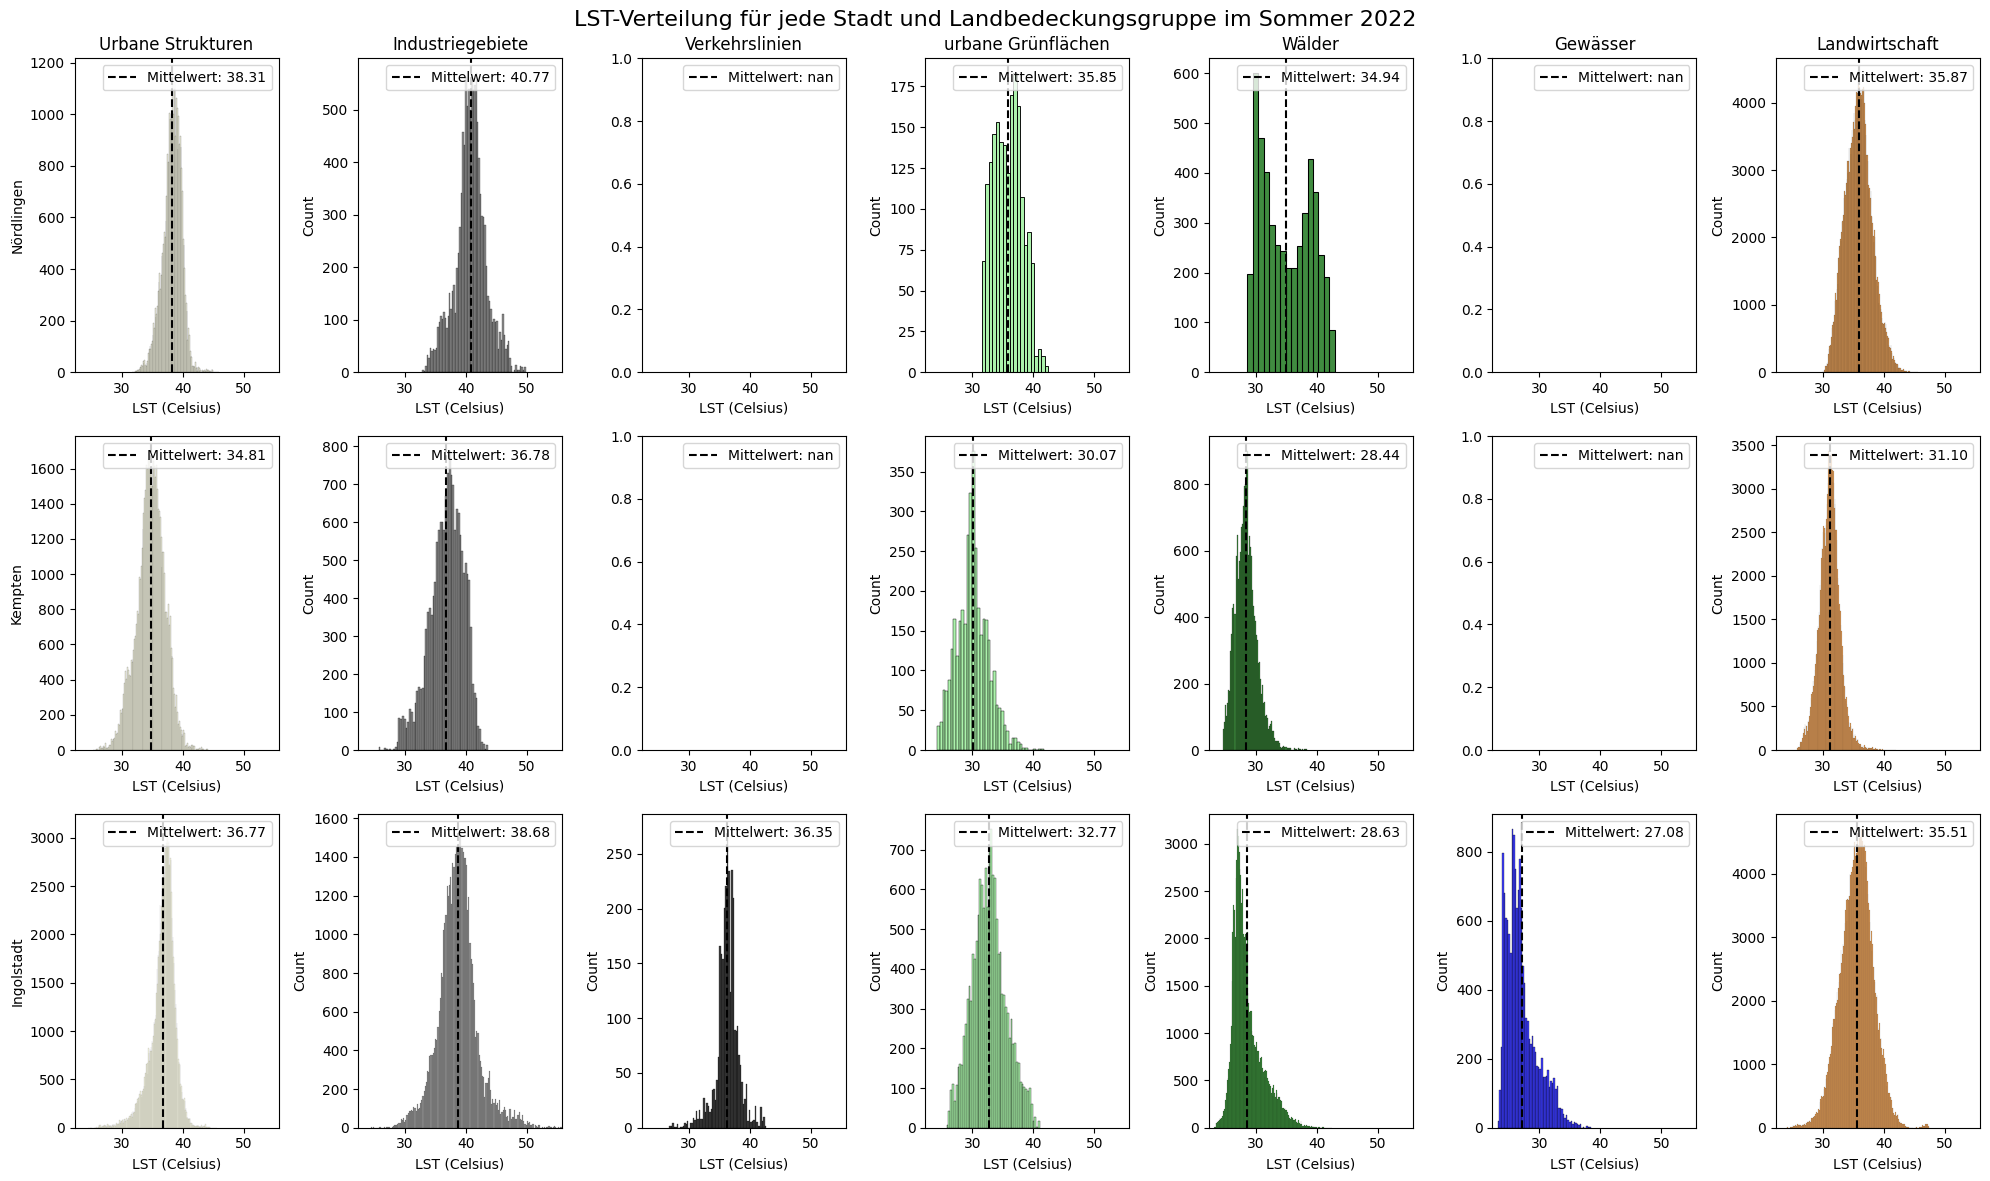

In [111]:
# Assuming you have the 'combined_noerdlingen', 'combined_kempten', 'combined_ingolstadt' GeoDataFrames

# Define the land use groups and their names
gruppen = {
    1: 'Urbane Strukturen',
    2: 'Industriegebiete',
    3: 'Verkehrslinien',
    4: 'urbane Grünflächen',
    5: 'Wälder',
    6: 'Gewässer',
    7: 'Landwirtschaft'
}

# Define colors for each land use group (optional)
farben = {
    'Urbane Strukturen': '#F5F5DC',  # beige
    'Industriegebiete': '#696969',  # dunkelgrau
    'Verkehrslinien': '#000000',  # schwarz
    'urbane Grünflächen': '#90EE90',  # hellgrün
    'Wälder': '#006400',  # dunkelgrün
    'Gewässer': '#0000FF',  # blau
    'Landwirtschaft': '#CC7722'  # ockerbraun
}

# Define a list of cities and their corresponding GeoDataFrames
cities = [
    ('Nördlingen', combined_noerdlingen),
    ('Kempten', combined_kempten),
    ('Ingolstadt', combined_ingolstadt)
]

# Create a figure and axes for the histograms
fig, axes = plt.subplots(nrows=len(cities), ncols=len(gruppen), figsize=(20, 12))  # Adjust figsize as needed
fig.suptitle('LST-Verteilung für jede Stadt und Landbedeckungsgruppe im Sommer 2022', fontsize=16)

# Iterate through each city and land use group
for i, (city_name, city_data) in enumerate(cities):
    for j, (group_id, group_name) in enumerate(gruppen.items()):
        ax = axes[i, j]  # Get the current axis

        # Filter data for the current city and group
        group_data = city_data[city_data['Landnutzung'] == group_id]['LST_Celsius']

        # Calculate mean LST for the current city and group
        mean_lst = group_data.mean()

        # Plot the histogram
        color = farben.get(group_name)  # Get color from 'farben' if available, otherwise use default
        sns.histplot(group_data, ax=ax, color=color)

        # Plot a vertical dashed line for the mean LST
        ax.axvline(mean_lst, color='black', linestyle='--', label=f'Mittelwert: {mean_lst:.2f}')

        # Set title and labels for the current subplot
        if i == 0:
            ax.set_title(group_name)  # Set title only for the top row
        if j == 0:
            ax.set_ylabel(city_name)  # Set y-label only for the first column
        ax.set_xlabel('LST (Celsius)')
        ax.legend()  # Add legend to display mean LST

# Get the minimum and maximum LST values across all cities and groups
min_lst = min(combined_df['LST_Celsius'].min() for _, combined_df in cities)
max_lst = max(combined_df['LST_Celsius'].max() for _, combined_df in cities)

# Set the x-axis limits for all subplots
for ax in axes.flatten():
    ax.set_xlim(min_lst, max_lst)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

Verkehrslinien und Gewässer werden bei Kempten und Nördlingen nicht erkannt, fehlen daher hier

Schrift und Beschriftungen noch anpassen